# Week 47

In [1]:
try:
    import fysisk_biokemi
    print("Already installed")
except ImportError:
    %pip install -q "fysisk_biokemi[colab] @ git+https://github.com/au-mbg/fysisk-biokemi.git"

------------------------------------------------------------------------

## Estimation of binding affinity

#### (a) Train estimation skills

Train your estimation skills using the widget below.

In [2]:
from fysisk_biokemi.widgets.utils.colab import enable_custom_widget_colab
from fysisk_biokemi.widgets import estimate_kd

enable_custom_widget_colab()
estimate_kd()

#### (b) Compare to quadratic

The widget below shows the curves for $\theta$ using both the simple
expression and the quadratic binding expression. Use it to determine how
large \[P\] has to be for them to be notably different.

In [3]:
from fysisk_biokemi.widgets.utils.colab import enable_custom_widget_colab
from fysisk_biokemi.widgets import visualize_simple_vs_quadratic

enable_custom_widget_colab()
visualize_simple_vs_quadratic()

------------------------------------------------------------------------

## Dialysis experiment

In [4]:
import numpy as np

A dialysis experiment was set up where equal amounts of a protein were
separately dialyzing against buffers containing different concentrations
of a ligand – each measurement was done in triplicate. The average
number of ligands bound per protein molecule, $\bar{n}$ were obtained
from these experiments. The corresponding concentrations of free ligand
and values are given in dataset `week47_7_dialysis_experiment.xlsx`.

#### (a) Load the dataset

In [5]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [6]:
df = uploader.get_dataframe()
display(df)

In [7]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('dialysis_experiment') # Load from package for the solution so it doesn't require to interact.
display(df)

#### (b) Explain calculation of $\bar{n}$

Explain how the values of $\bar{n}$ is calculated when knowing the
concentrations of ligand inside and outside the dialysis bag, as well as
the total concentration of the protein, \[$\text{P}_{\text{tot}}$\].

#### (c) Molar concentrations

Convert the concentrations of free ligand to SI-units given in M, add it
as a row to the `DataFrame`.

In [8]:
df['Free Ligand [L](M)'] = df['Free ligand [L](µM)'] * 10**(-6)
display(df)

#### (c) Plot the data

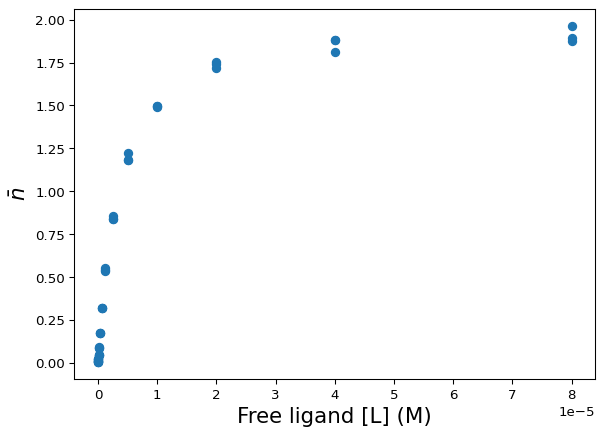

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(df['Free Ligand [L](M)'], df['n-bar'], 'o')
ax.set_xlabel('Free ligand [L] (M)', fontsize=16)
ax.set_ylabel(r'$\bar{n}$', fontsize=16)
plt.show()

#### (d) Prepare for fitting

Now we want to fit the data to extract $K_D$ and $\nu_{\text{max}}$, by
using the equation

$$
\nu([L_{\text{free}}]) = \nu_{\text{max}} \frac{[L_{\text{free}}]}{K_D + [L_{\text{free}}]}
$$

To do so we need to implmenet it as a Python function

In [12]:
def nu(L, nu_max, K_D):
    return nu_max * L / (K_D + L)

print(f"{nu(1, 1, 1) = }") # Should give 1/2
print(f"{nu(21, 47, 2.5) = }") # Should give 42

nu(1, 1, 1) = 0.5
nu(21, 47, 2.5) = 42.0

#### (e) Actually fitting

> **Important**
>
> Fitting refers to finding the parameters that make an assumed
> functional form best ‘fit’ the data. Programmatically we will use the
> `curve_fit` from the `scipy` package to do so. The signature of this
> function looks like this
>
> ``` python
> curve_fit(function, 
>             x_data, 
>             y_data, 
>             p0=[param_1, param_2, ...])
> ```
>
> The arguments are
>
> -   `function`: A python function where the **first** argument is the
>     independent variable, and other arguments are the parameters of
>     the functions.
> -   `x_data`: The observed values of the independent variable.
> -   `y_data`: The observed values of the dependent variable.
> -   `p0`: Initial guesses for the parameters.
>
> When called `curve_fit` starts by calculating how well the functions
> fits the data with the initial parameters in `p0` and then iteratively
> improves the fit by trying new values for the parameters in an
> intelligent way.
>
> The found parameters will generally depend on `p0` and it is therefore
> necessary to provide a good (or good enough) guess for `p0`.
>
> Generally, the best way to learn more about a function is to read it’s
> documentation and then play around with it. The documentation is in
> this case on the [SciPy
> website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).
> You don’t need to read it, unless you want more details.

Finish the code to perform the fitting in the cell below.

In [14]:
from scipy.optimize import curve_fit

# Choose the variables from the dataframe
x = df['Free Ligand [L](M)']
y = df['n-bar']

# Initial guess
K_D_guess = 10**(-5)
nu_max_guess = 1
p0 = [K_D_guess, nu_max_guess]

# Curve fit
popt, pcov = curve_fit(nu, x, y, p0=p0)
nu_max_fit, K_D_fit = popt
print(f"{nu_max_fit = :1.3f} ")
print(f"{K_D_fit = :e}")

nu_max_fit = 2.009 
K_D_fit = 3.395997e-06

Are the parameters you find reasonable? How can you tell if they are
reasonable by looking at the plot you made earlier?

#### (f) Plot with fit

When we have the fitted parameters we can calculate and plot the
function. To do so we make an array of values for the independent
variable and use our function to calculate the dependent variable

In [16]:
# This makes 50 equally spaced points between 0 and the highest concentration x 1.2
L = np.linspace(0, x.max()*1.2, 50) 

# Calculate: 
nu_calc = nu(L, nu_max_fit, K_D_fit)

Now that we calculated the dependent variable we can plot the fit along
with the data.

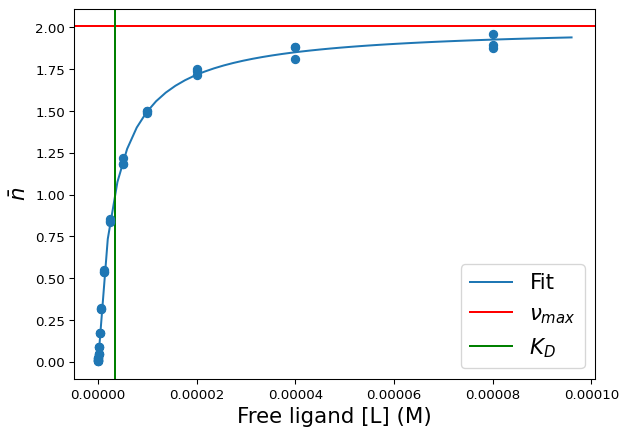

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot the fitted curve
ax.plot(L, nu_calc, label='Fit')

# Straight lines indicating the parameters 
ax.axhline(nu_max_fit, color='red', label=r'$\nu_{max}$')
ax.axvline(K_D_fit, color='green', label=r'$K_D$')

# Same as before
ax.plot(df['Free Ligand [L](M)'], df['n-bar'], 'o', color='C0')
ax.set_xlabel('Free ligand [L] (M)', fontsize=16)
ax.set_ylabel(r'$\bar{n}$', fontsize=16)
ax.legend(fontsize=16)
plt.show()

------------------------------------------------------------------------

## ADP binding to pyruvate kinase.

The binding of ADP to the enzyme pyruvate kinase was measured by
fluorescence. The enzyme concentration was 4 μM throughout the
titration, and each measurement was done in triplicate. The binding
results were obtained at 310 K and are given in the `.csv`-file
`week47_8_adp_pyruvate.csv`.

#### (a) Load the dataset

As always, use the widget to load the dataset

In [18]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [19]:
df = uploader.get_dataframe()
display(df)

In [20]:
import pandas as pd
pd.set_option('display.max_rows', 6)
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('adp_pyruvate') # Load from package for the solution so it doesn't require to interact.
display(df)

27 rows × 2 columns

#### (b) Units

The concentrations in the dataset are given in mM, add a new column to
the `DataFrame` with the units given in M.

In [22]:
df['[ADPtot](M)'] = df['[ADPtot](mM)'] * 10**(-3)
display(df)

27 rows × 3 columns

#### (c) Free ADP concentration

For each value of $\bar{n}$ calculate the concentration of
\[ADP$_\text{free}$\] from \[ADP$_\text{tot}$\] and \[enzyme\].

In [24]:
enzyme_conc = 4 * 10**(-6)
df['[ADPfree](M)'] = df['[ADPtot](M)'] - df['nbar'] * enzyme_conc
display(df)

27 rows × 4 columns

#### (d) Make a plot

Make a plot of the free ligand concentration versus $\bar{n}$.

Text(0, 0.5, '$\\bar{n}$')

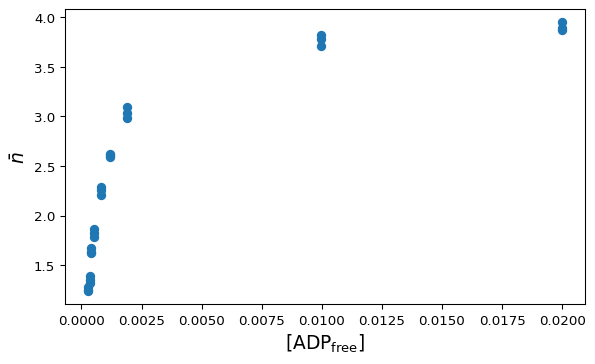

In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df['[ADPfree](M)'], df['nbar'], marker='o', linestyle='none', label='Observations')
ax.set_xlabel(r'$[\text{ADP}_{\text{free}}]$', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)

#### (f) Preparing for fitting

To fit we need a implement the function we want to fit the parameters
of, the functional form is

$$
n = n_{\text{max}} \frac{[L]^n}{K_D + [L]^n}
$$

In [28]:
def n_bound(L, n_max, K_D, n_exp):
    return n_max * L**n_exp / (K_D + L**n_exp)

print(f"{n_bound(1, 1, 1, 1) = }") # Should give 1/2
print(f"{n_bound(21, 47, 2.5, 1) = }") # Should give 42
print(f"{n_bound(21, 47, 2.5, 2) = }") # Should give 46.73..

n_bound(1, 1, 1, 1) = 0.5
n_bound(21, 47, 2.5, 1) = 42.0
n_bound(21, 47, 2.5, 2) = 46.73506200676437

#### (e) Fitting

Finish the code below to create a fit.

In [30]:
from scipy.optimize import curve_fit

# Choose the variables from the dataframe
x = df['[ADPfree](M)']
y = df['nbar']

# Initial guess
K_D_guess = 1*10**(-3) # Your initial guess for K_D 
nu_max_guess = 1 # Your initial guess for nu_max
n_exp = 2 # Your initial guess for the exponent.
p0 = [K_D_guess, nu_max_guess, n_exp]

# Bounds
bounds = (0, np.inf) # We limit the parameters to be positve.

# Curve fit
popt, pcov = curve_fit(n_bound, x, y, p0=p0, bounds=bounds)

# Print the parameters
n_max_fit, K_D_fit, n_exp_fit = popt
print(f"{n_max_fit = :1.3f} ")
print(f"{K_D_fit = :e}")
print(f"{n_exp_fit = :1.3f} ")

n_max_fit = 4.013 
K_D_fit = 5.641467e-04
n_exp_fit = 1.016 

Once we’ve obtained the fitted parameters we can plot the fit together
with the data.

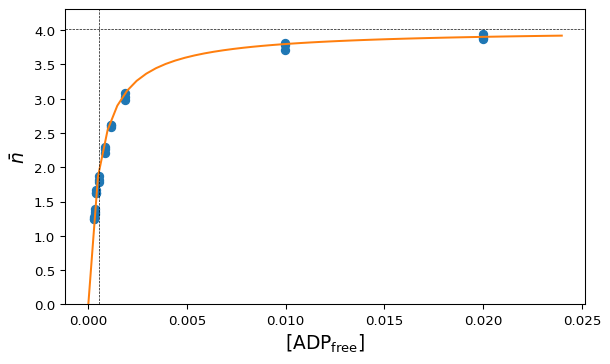

In [32]:
L = np.linspace(0, 1.2 * x.max(), 50)
n = n_bound(L, n_max_fit, K_D_fit, 1)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df['[ADPfree](M)'], df['nbar'], 'o', label='Observations')
ax.plot(L, n)
ax.axvline(K_D_fit, color='k', linewidth=0.5, linestyle='--')
ax.axhline(n_max_fit, color='k', linewidth=0.5, linestyle='--')


ax.set_xlabel(r'$[\text{ADP}_{\text{free}}]$', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
ax.set_ylim([0, n.max()*1.1])

### Free energy

Calculate the free energy for the association of the ADP-pyruvate kinase
complex assuming
$R = 8.314472 \times 10^{-3} \ \frac{\text{kJ}}{\text{mol} \cdot \text{K}}$
and $T = 310 \ \text{K}$.

> **Tip**
>
> Consider the difference between association and dissociation

Start by defining the two given constants as variables

In [34]:
R = 8.314472 * 10**(-3)
T = 310

And do the calculation

In [35]:
delta_G = ...
print(f"{delta_G = :.3f} kJ/mol")

In [36]:
delta_G = R * T * np.log(K_D_fit)
print(f"{delta_G = :.3f} kJ/mol")

delta_G = -19.280 kJ/mol

------------------------------------------------------------------------

## Interpretation of binding data.

In [37]:
import numpy as np

The `week48_1_interpret.xlsx` contains a protein binding dataset.

#### (a) Load the dataset

Load the dataset using the widget below

In [38]:
import numpy as np
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [39]:
df = uploader.get_dataframe()
display(df)

In [40]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('interpret_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

45 rows × 2 columns

#### (b) SI Units

Add a new column to the `DataFrame` with the ligand concentration in SI
units.

In [42]:
df['[L]_(M)'] = df["[L]_(uM)"] * 10**(-6)
display(df)

45 rows × 3 columns

#### (c) Plot the data

Make plots of the binding data directly with a linear and logarithmic
x-axis.

Estimate $K_D$ by visual inspection of these plots!

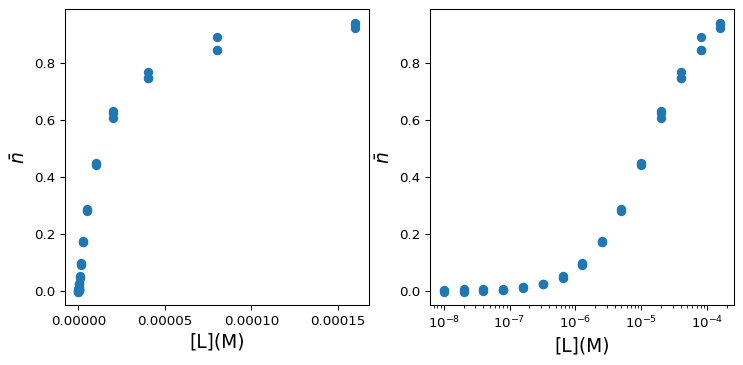

In [44]:
import matplotlib.pyplot as plt

# This makes a figure with two axes.
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Can with [0] to plot in the first axis.
ax = axes[0]
ax.plot(df['[L]_(M)'], df['nbar'], 'o') # Replace ... with your code.
ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)

ax = axes[1]
ax.plot(df['[L]_(M)'], df['nbar'], 'o')
ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
ax.set_xscale('log')

> **Note**
>
> Ths command `ax.set_xscale('log')` tells `matplotlib` that we want the
> x-axis to use a log-scale.

In [46]:
k_d_estimate = 5 * 10**(-5)

#### (d) Make a fit

Make a fit to determine $K_D$, as always we start by implementing the
function to fit with

In [48]:
def n_bar(L, K_D):
    return L / (L + K_D)

And then we can make the fit

In [50]:
from scipy.optimize import curve_fit

# Choose the variables from the dataframe
x = df['[L]_(M)']
y = df['nbar']

# Initial guess
p0 = [k_d_estimate]

# Bounds
bounds = (0, np.inf) # We limit the parameters to be positve.

# Curve fit
popt, pcov = curve_fit(n_bar, x, y, p0=p0, bounds=bounds)

# Print the parameters
k_d_fit = popt[0]
print(f"{k_d_fit = :e}")

k_d_fit = 1.245798e-05

#### Compare

Use the figure below to compare your guess with the fitted value.

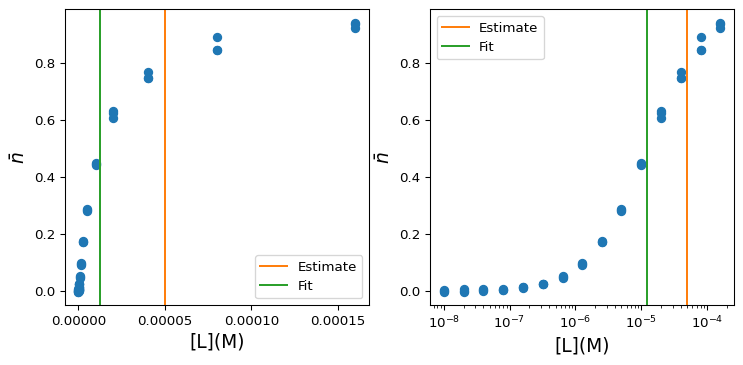

In [51]:
import matplotlib.pyplot as plt

# This makes a figure with two axes.
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Can with [0] to plot in the first axis.
ax = axes[0]
ax.plot(df['[L]_(M)'], df['nbar'], 'o')
ax.axvline(k_d_estimate, label='Estimate', color='C1')
ax.axvline(k_d_fit, label='Fit', color='C2')
ax.legend()

ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)

ax = axes[1]
ax.plot(df['[L]_(M)'], df['nbar'], 'o')
ax.set_xlabel('[L](M)', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
ax.axvline(k_d_estimate, label='Estimate', color='C1')
ax.axvline(k_d_fit, label='Fit', color='C2')
ax.legend()
ax.set_xscale('log')

#### Saturation

Based on the value of $K_D$ found from the fit,

-   At which concentration do you expect 10% saturation?
-   At which concentration do you expect 90% saturation?

------------------------------------------------------------------------

## Determination of type and strength of cooperativity

In [52]:
import matplotlib.pyplot as plt
import numpy as np

The binding of NAD+ to the protein yeast glyceraldehyde 3-phosphate
dehydrogenase (GAPDH) was studied using equilibrium dialysis. The enzyme
concentration was 71 μM. The concentration of
$[\text{NAD}^{+}_\text{free}]$ and the corresponding values of $\bar{n}$
were determined with the resulting data found in the dataset
`week48_2_determination_coop.xlsx`.

#### (a) Load the dataset

Load the dataset using the widget below

In [53]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [54]:
df = uploader.get_dataframe()
display(df)

In [55]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('determination_coop_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

9 rows × 4 columns

#### (b) Averaging and units.

Start by adding a new column to the `DataFrame` with the average value
of $\bar{n}$ across the three series

> **Tip**
>
> Remember that you can set a new column based on a computation using
> one or more other columns, e.g. 
>
> ``` python
> df['new_col'] = df['col1'] + df['col2']
> ```

In [57]:
df['nbar_avg'] = (df['nbar1'] + df['nbar2'] + df['nbar3']) / 3

Now also add a column with the ligand concentration in SI units with the
column-name `[NAD+free]_(M)`.

In [59]:
df['[NAD+free]_(M)'] = df['[NAD+free]_(uM)'] * 10**(-6)
display(df)

9 rows × 6 columns

Finally, set the concentration of the GADPH in SI units

In [60]:
 c_gadph = 71 * 10**(-6)

#### (c) Plot

Make a plot of the average $\bar{n}$ as a function of
$[\text{NAD}^{+}_\text{free}]$.

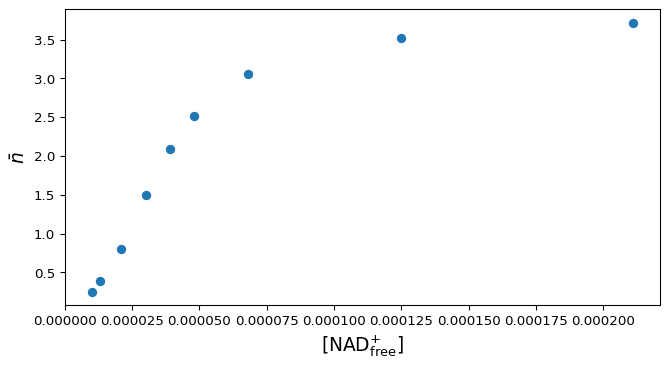

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df['[NAD+free]_(M)'], df['nbar_avg'], 'o')
ax.set_xlabel(r'$[\text{NAD}^{+}_\text{free}]$', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
plt.show()

#### (d) Scatchard plot

Make a Scatchard plot based on the average $\bar{n}$.

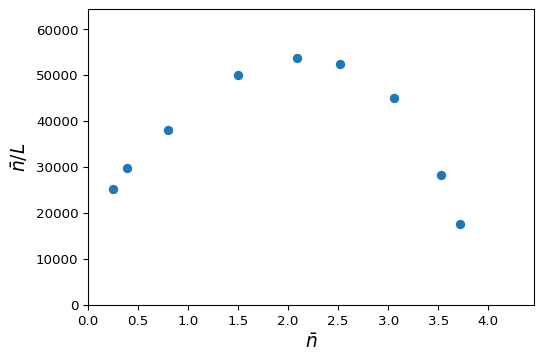

In [64]:
# Calculate nbar / L 
nbar_over_L = df['nbar_avg'] / df['[NAD+free]_(M)']

fig, ax = plt.subplots(figsize=(6, 4)) 
ax.plot(df['nbar_avg'], nbar_over_L, 'o')
ax.set_xlabel(r'$\bar{n}$', fontsize=14)
ax.set_ylabel(r'$\bar{n}/L$', fontsize=14)
ax.set_xlim([0, df['nbar_avg'].max()*1.2])
ax.set_ylim([0, nbar_over_L.max() * 1.2])

#### (e) Binding sites

How many binding sites does GAPDH contain for $\text{NAD}^{+}$?

#### (f) Cooperativity

What type of cooperativity do the plots indicate?

#### (g) Fit

Make a fit using the functional form

$$
\bar{n} = N \frac{[L]^h}{K_D + [L]^h}
$$

As usual, start by defining the function in Python

In [65]:
def n_bar(L, N, k_d, h):
    return N * L**h / (k_d + L**h)

Now we can fit

In [68]:
from scipy.optimize import curve_fit

# Choose the variables from the dataframe
x = np.concatenate([df['[NAD+free]_(M)'], df['[NAD+free]_(M)'], df['[NAD+free]_(M)']])
y = np.concatenate([df['nbar1'], df['nbar2'], df['nbar3']])

# Initial guess
p0 = [4, 1*10**(-4), 1]

# Bounds
bounds = (0, np.inf) # We limit the parameters to be positve.

# Curve fit
popt, pcov = curve_fit(n_bar, x, y, p0=p0, bounds=bounds)

# Print the parameters
N_fit, k_d_fit, h_fit = popt
print(f"{N_fit = :.3f}")
print(f"{k_d_fit = :e}")
print(f"{h_fit = :.3f}")

N_fit = 4.048
k_d_fit = 1.278350e-08
h_fit = 1.791

> **Note**
>
> The function `np.concatenate` takes a number of arrays and makes a new
> array that consisting of the originals one after each other. For
> example,
>
> ``` python
> A = np.array([1, 2, 3])
> B = np.array([4, 5, 6])
> C = np.concatenate([A, B])
> print(C)
> ```
>
>     [1 2 3 4 5 6]

#### (h) Plot with fit

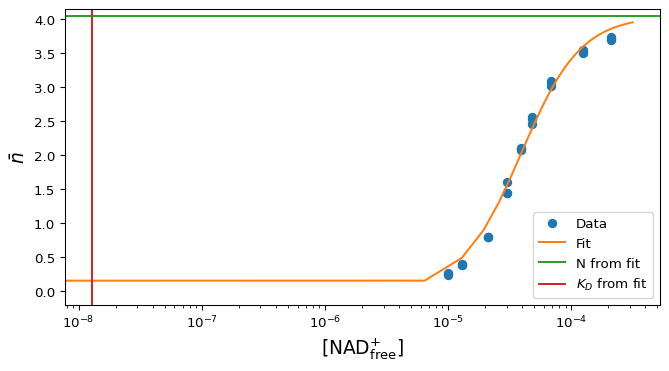

In [71]:
L = np.linspace(0, df['[NAD+free]_(M)'].max()*1.5)
n_bar_fit = n_bar(L, N_fit, k_d_fit, h_fit)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(L, n_bar_fit, '-', label='Fit')
ax.axhline(N_fit, color='C2', label='N from fit')
ax.axvline(k_d_fit, color='C3', label=r'$K_D$ from fit')
ax.set_xscale('log')
ax.set_xlabel(r'$[\text{NAD}^{+}_\text{free}]$', fontsize=14)
ax.set_ylabel(r'$\bar{n}$', fontsize=14)
ax.legend()
plt.show()

------------------------------------------------------------------------

## Competition in ligand binding

Below is given the general expression for saturation of a binding site
by one of the ligands, $L$, when two ligands $L$ and $C$ are competing
for binding to the same site on a protein. Assume that $[P_T] = 10^{-9}$
$\mathrm{M}$.

$$
\theta = \frac{[PL]}{[P_T]} = \frac{1}{\frac{K_D}{[L]}\left(1 + \frac{[C]}{K_C}\right) + 1}
$$

Consider these four situations

| \# | $K_D$ | $[L_T]$ | $K_C$ | $[C_T]$ |
|------|-----------------|-----------------|-----------------|-----------------|
| 1 | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-3}$ $\mathrm{M}$ |  | $0$ |
| 2 | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-3}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ | $1·10^{-2}$ $\mathrm{M}$ |
| 3 | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-3}$ $\mathrm{M}$ | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-3}$ $\mathrm{M}$ |
| 4 | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-5}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ | $1·10^{-6}$ $\mathrm{M}$ |

##### (a) Explain simplification

Explain how the fact that $[P_T]$ is much smaller than $[L_T]$ and
$[C_T]$ simplifies the calculations using the above equation.

#### (b) Ligand degree of saturation

Calculate the degree of saturation of the protein with ligand $L$ in the
four situations.

Start by writing a Python function that calculates the degree of
saturation $\theta$.

In [73]:
def bound_fraction(L, C, Kd, Kc):
    return 1 / ((Kd / L)*(1+(C/Kc))+1)

Then use that function to calculate $\theta$ for each situation.

In [75]:
theta_L_1 = bound_fraction(10**(-3), 0, 10**(-5), 10**(-18))
theta_L_2 = bound_fraction(10**(-3), 10**(-2), 10**(-5), 10**(-6))
theta_L_3 = bound_fraction(10**(-3), 10**(-3), 10**(-5), 10**(-5))
theta_L_4 = bound_fraction(10**(-5), 10**(-6), 10**(-5), 10**(-6))
print(f"{theta_L_1 = :.3f}")
print(f"{theta_L_2 = :.3f}")
print(f"{theta_L_3 = :.3f}")
print(f"{theta_L_4 = :.3f}")

theta_L_1 = 0.990
theta_L_2 = 0.010
theta_L_3 = 0.498
theta_L_4 = 0.333

#### (c) Competitor degree of saturation

What is the degree of saturation with respect to the competitor $C$ in
#1, #2 and #4?

In [77]:
theta_C_1 = 0 # [C] = 0
theta_C_2 = bound_fraction(10**(-2), 10**(-3), 10**(-6), 10**(-5))
theta_C_3 = bound_fraction(10**(-3), 10**(-3), 10**(-5), 10**(-5))
theta_C_4 = bound_fraction(10**(-6), 10**(-5), 10**(-6), 10**(-5))

print(f"{theta_C_1 = :.3f}")
print(f"{theta_C_2 = :.3f}")
print(f"{theta_C_3 = :.3f}")
print(f"{theta_C_4 = :.3f}")

theta_C_1 = 0.000
theta_C_2 = 0.990
theta_C_3 = 0.498
theta_C_4 = 0.333

#### (d) Fraction of $[P_{\mathrm{free}}]$

What is the fraction of $[P_{\mathrm{free}}]$ in #2, #3, #4?

> **Tip**
>
> Consider how to express the fraction of $[P_{\mathrm{free}}]$ in terms
> of `theta_L_X` and `theta_C_X`.

In [79]:
theta_free_1 = 1 - (theta_L_1 + theta_C_1)
theta_free_2 = 1 - (theta_L_2 + theta_C_2)
theta_free_3 = 1 - (theta_L_3 + theta_C_3)
theta_free_4 = 1 - (theta_L_4 + theta_C_4)

print(f"{theta_free_1 = :.3f}")
print(f"{theta_free_2 = :.3f}")
print(f"{theta_free_3 = :.3f}")
print(f"{theta_free_4 = :.3f}")

theta_free_1 = 0.010
theta_free_2 = 0.000
theta_free_3 = 0.005
theta_free_4 = 0.333